# WZGW Projekt 1 - układy współrzędnych na elipsoidzie 
Nr indeksu: 311512

__Cel ćwiczenia:__ Zapoznanie się z układami współrzędnych na elipsoidzie obrotowej. Poznanie metod wizualizacji lotu samolotu na podstawie danych geodezyjnych.

__Układ geodezyjny:__ Układ współrzędnych, w którym do jednoznacznego wyznaczenia pozycji na elipsoidzie podajemy szerokość geodezyjną (oznaczana małą literą grecką _fi_), długość geodezyjną (oznaczana małą literą grecką _lambda_) i ewentualnie wysokość nad elipsoidą (oznaczana małą literą _h_). W każdym dowolnym punkcie na elipsoidzie szerokość (_latitude_) to kąt jaki tworzy prosta normalna z płaszczyzną równika (przedział -90 +90 stopni), długość (_longitude_) to kąt pomiędzy południkiem zerowym, a południkiem przechodzącym przez ten punkt. Wysokość mierzona jest w kierunku normalnej.

__Układ ortokartezjański:__ Układ współrzędnych, w którym do jednoznacznego wyznaczenia pozycji na elipsoidzie podajemy wartości x, y, z. Początek układu znajduje się w środku geometrycznym elipsoidy. Istnieją wzory matematyczne umożliwiające przejście pomiędzy układami.

__Układ topocentryczny:__ Układ współrzędnych, którego środek jest w dowolnie ustalonym punkcie na powierzchni elipsoidy. Względem tego punktu odpowiednio ustawione są osie __n__ (north), __e__ (east), __u__ (up). Nie ważne jaki punkt wybierzemy, każdy inny punkt na powierzchni elipsoidy będzie miał ujemną współrzędną __u__.
    
    x->n    y->e    z->u  
    
Zaimplementowałem funkcje do zamiany współrzędnych, które jako domyślne przyjmują parametry (mimośród, długoość półosi wielkiej) powszechnie używanej elipsoidy GRS 80, jednak można podać również parametry innych elipsoid obrotowych. Zastosowanie układu neu jest mniej praktyczne niż układu geodezyjnego w tym ćwiczeniu gdyż większość (jeśli nie wszystkie) funkcji z pythonowych modułów do wizualizacji danych geodezyjnych oczekuje danych postaci (_lambda_, _fi_). Jest to logiczne, ponieważ układ geodezyjny jest ogólnie najczęściej wykorzystywanym układem jeśli chodzi o dane geodezyjne. Natomiast układ topocentryczny "neu" przydał się do wizualizacji lotu samolotu z punktu odniesienia stacjonarnego obserwatora. Mając dane w tym układzie możemy też łatwo się dowiedzieć kiedy samolot zniknął za horyzontem (wystarzczy spojrzeć na znak współrzędnej _u_).

In [60]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import folium
from shapely.geometry import Point
from math import *
# X, Y, Z - współrzędne geodezyjne, nie matematyczne...
%matplotlib inline
plt.style.use('seaborn-poster')
# sns.set_theme()

# Funkcje do zamiany współrzędnych

In [61]:
def delta_vector(A, B):
    """zwraca wektor delt między dwoma punktami A do B. A,B: np.array()"""
    if len(A) != len(B):
        print("A and B dimensions are not the same (they should be)")
        return
    delts = []
    for i in range(len(A)):
        delts.append(B[i]-A[i])
    return np.array(delts)

In [62]:
def geo2xyz(fi, lam, h, a=6378137, e2=0.00669437999013):
    # dorobic domusllne a i e2 dla elipsoidy GRS80
    """funkcja zamienia współrzędne geodezyjne na kartezjańskie fi, lam podajemy w radianach do wzorów, do fcji w deg"""
    fi = np.deg2rad(fi)
    lam = np.deg2rad(lam)
    N = a / np.sqrt(1 - e2 * np.sin(fi) ** 2)
    x = (N + h) * np.cos(fi) * np.cos(lam)
    y = (N + h) * np.cos(fi) * np.sin(lam)
    z = (N * (1 - e2) + h) * np.sin(fi)
    return np.array([x, y, z])

In [63]:
def xyz2neu(fi, lam, A, B):
    # def xyz2neu(A:punktodniesienia/startowy, B:koniecwektora):
    """funkcja zamienia wsp kartezjańskie na topocentryczne neu
    A, B reprezentują punkty, A to początek, B to koniec wektora
    A, B są typu np.array i mają 3 współrzędne: x, y, z
    fi, lam to współrzędne punktu A potrzebne do macierzy obrotu"""
    # x, y, z -> north, east, up
    # fi, lambda, lotniska
    # wektor AB (od lotniska do samolotu)
    fi = np.deg2rad(fi)
    lam = np.deg2rad(lam)
    rotation_matrix = np.array([
        [-1*np.sin(fi)*np.cos(lam), -1*np.sin(lam), np.cos(fi)*np.cos(lam)],
        [-1*np.sin(fi)*np.sin(lam), np.cos(lam), np.cos(fi)*np.sin(lam)],
        [np.cos(fi), 0, np.sin(fi)]
    ])
    vector = delta_vector(A, B)
    return rotation_matrix.transpose() @ vector

# Wczytanie i obróbka danych

In [64]:
# orig_df = pd.read_csv('radar.csv', sep=';')
orig_df = pd.read_csv('787_test_flight.csv', sep=';')

In [65]:
# orig_df.info()

In [66]:
# orig_df.describe(include='all')

In [67]:
# main_df.loc[0].xyz


In [68]:
main_df = orig_df
pd.set_option('display.max_colwidth', None)
main_df['xyz'] = pd.Series(map(geo2xyz, main_df['Latitude'], main_df['Longitude'], main_df['Meters']))

In [69]:
A = main_df.loc[0].xyz
latA = main_df.loc[0].Latitude
lonA = main_df.loc[0].Longitude
main_df['neu'] = pd.Series(map(xyz2neu, 
                               list(itertools.repeat(latA, main_df.shape[0])), 
                               list(itertools.repeat(lonA, main_df.shape[0])), 
                               list(itertools.repeat(A, 
                                                     main_df.shape[0])), 
                               main_df['xyz']
                              )
                          )

In [70]:
main_df['n'] = pd.Series(map(lambda x: x[0], main_df['neu']))

In [71]:
main_df['e'] = pd.Series(map(lambda x: x[1], main_df['neu']))

In [72]:
main_df['u'] = pd.Series(map(lambda x: x[2], main_df['neu']))

In [73]:
main_df['tanA'] = main_df['e']/main_df['n']

In [74]:
main_df['s'] = np.sqrt(main_df['n']**2 + main_df['e']**2 + main_df['u']**2)

In [75]:
main_df['cosz'] = main_df['u']/main_df['s']

In [76]:
# main_df

In [77]:
main_df.dropna(axis=0, how='all', thresh=4, inplace=True)

In [78]:
main_df

Latitude  Longitude  Meters  kmh  \
0      47.5520  -122.3225     427  328   
1      47.5625  -122.3335     549  364   
2      47.5748  -122.3465     671  394   
3      47.5874  -122.3597     762  428   
4      47.6010  -122.3735     884  462   
...        ...        ...     ...  ...   
1780   47.4632  -122.2461     366  269   
1781   47.4715  -122.2530     305  262   
1782   47.4796  -122.2599     274  259   
1783   47.4885  -122.2674     213  254   
1784   47.4970  -122.2745     152  253   

                                                                xyz  \
0     [-2306035.5665033865, -3644617.9825471956, 4683716.758970279]   
1     [-2306318.4747251146, -3643516.7828174015, 4684594.678398807]   
2      [-2306649.0460425075, -3642210.125473728, 4685607.499627402]   
3     [-2306967.3513167817, -3640856.7853557295, 4686619.753359847]   
4       [-2307290.364692626, -3639427.429322005, 4687729.681151799]   
...                                                             ...   
1780      [-2305036.17345169, -3653812.304186043, 4677002.33037073]   
1781    [-2305091.263931832, -3652924.707902804, 4677581.230722642]   
1782    [-2305165.702595342, -3652068.0903510065, 4678167.10378719]   
1783   [-2305232.3337930315, -3651114.716822785, 4678790.869500951]   
1784   [-2305290.731134831, -3650205.1273612273, 4679384.462834926]   

                                                               neu  \
0                                                  [0.0, 0.0, 0.0]   
1     [1167.5671350807866, -827.8662808374785, 121.83938582212522]   
2     [2535.491615330666, -1805.8653010624714, 243.24030643002152]   
3     [3936.981805394761, -2798.4594216880328, 333.17083693380755]   
4       [5449.936867244872, -3835.676644883588, 453.5179523793945]   
...                                                            ...   
1780   [-9870.578721327667, 5760.597919184485, -71.24330398200436]   
1781   [-8948.136574644033, 5239.459857043972, -130.4323796241888]   
1782  [-8047.938956571274, 4718.535414767792, -159.82568314484251]   
1783   [-7058.753734461781, 4152.47479065233, -219.25995498191423]   
1784    [-6113.985704296686, 3616.78285281868, -278.9575358698121]   

                n            e           u      tanA             s      cosz  
0        0.000000     0.000000    0.000000       NaN      0.000000       NaN  
1     1167.567135  -827.866281  121.839386 -0.709052   1436.461078  0.084819  
2     2535.491615 -1805.865301  243.240306 -0.712235   3122.344162  0.077903  
3     3936.981805 -2798.459422  333.170837 -0.710813   4841.714952  0.068813  
4     5449.936867 -3835.676645  453.517952 -0.703802   6679.813299  0.067894  
...           ...          ...         ...       ...           ...       ...  
1780 -9870.578721  5760.597919  -71.243304 -0.583613  11428.818324 -0.006234  
1781 -8948.136575  5239.459857 -130.432380 -0.585536  10370.057876 -0.012578  
1782 -8047.938957  4718.535415 -159.825683 -0.586304   9330.564943 -0.017129  
1783 -7058.753734  4152.474791 -219.259955 -0.588273   8192.504263 -0.026763  
1784 -6113.985704  3616.782853 -278.957536 -0.591559   7109.131923 -0.039239  

[1785 rows x 12 columns]

# Wizualizacja lotu
1. Mapa interaktywna
2. Trasa lotu
3. Nad którymi krajami przeleciał samolot?
4. Wykresy w układzie topocentrycznym neu
5. Więcej map 

### 1. Mapa interaktywna

In [79]:
def pprintdms(wsp):
    """printuje/returnuje współrzędną w formacie stopnie, minuty, sekundy kątowe. Wejście to stopnie dziesiętne"""
    d = floor(wsp)
    m = floor((wsp-d)*60)
    s = round((wsp-d-m/60)*3600, 5)
#     print(f"{d}°{m}′{s}″")          # 
    s = '{:.5f}'.format(s)       #
    return f"{d}°{m}′{s}″"

In [80]:
main_df['pfi'] = main_df.apply(lambda row: pprintdms(row[0]), axis=1)
main_df['plam'] = main_df.apply(lambda row: pprintdms(row[1]), axis=1)
main_df

Latitude  Longitude  Meters  kmh  \
0      47.5520  -122.3225     427  328   
1      47.5625  -122.3335     549  364   
2      47.5748  -122.3465     671  394   
3      47.5874  -122.3597     762  428   
4      47.6010  -122.3735     884  462   
...        ...        ...     ...  ...   
1780   47.4632  -122.2461     366  269   
1781   47.4715  -122.2530     305  262   
1782   47.4796  -122.2599     274  259   
1783   47.4885  -122.2674     213  254   
1784   47.4970  -122.2745     152  253   

                                                                xyz  \
0     [-2306035.5665033865, -3644617.9825471956, 4683716.758970279]   
1     [-2306318.4747251146, -3643516.7828174015, 4684594.678398807]   
2      [-2306649.0460425075, -3642210.125473728, 4685607.499627402]   
3     [-2306967.3513167817, -3640856.7853557295, 4686619.753359847]   
4       [-2307290.364692626, -3639427.429322005, 4687729.681151799]   
...                                                             ...   
1780      [-2305036.17345169, -3653812.304186043, 4677002.33037073]   
1781    [-2305091.263931832, -3652924.707902804, 4677581.230722642]   
1782    [-2305165.702595342, -3652068.0903510065, 4678167.10378719]   
1783   [-2305232.3337930315, -3651114.716822785, 4678790.869500951]   
1784   [-2305290.731134831, -3650205.1273612273, 4679384.462834926]   

                                                               neu  \
0                                                  [0.0, 0.0, 0.0]   
1     [1167.5671350807866, -827.8662808374785, 121.83938582212522]   
2     [2535.491615330666, -1805.8653010624714, 243.24030643002152]   
3     [3936.981805394761, -2798.4594216880328, 333.17083693380755]   
4       [5449.936867244872, -3835.676644883588, 453.5179523793945]   
...                                                            ...   
1780   [-9870.578721327667, 5760.597919184485, -71.24330398200436]   
1781   [-8948.136574644033, 5239.459857043972, -130.4323796241888]   
1782  [-8047.938956571274, 4718.535414767792, -159.82568314484251]   
1783   [-7058.753734461781, 4152.47479065233, -219.25995498191423]   
1784    [-6113.985704296686, 3616.78285281868, -278.9575358698121]   

                n            e           u      tanA             s      cosz  \
0        0.000000     0.000000    0.000000       NaN      0.000000       NaN   
1     1167.567135  -827.866281  121.839386 -0.709052   1436.461078  0.084819   
2     2535.491615 -1805.865301  243.240306 -0.712235   3122.344162  0.077903   
3     3936.981805 -2798.459422  333.170837 -0.710813   4841.714952  0.068813   
4     5449.936867 -3835.676645  453.517952 -0.703802   6679.813299  0.067894   
...           ...          ...         ...       ...           ...       ...   
1780 -9870.578721  5760.597919  -71.243304 -0.583613  11428.818324 -0.006234   
1781 -8948.136575  5239.459857 -130.432380 -0.585536  10370.057876 -0.012578   
1782 -8047.938957  4718.535415 -159.825683 -0.586304   9330.564943 -0.017129   
1783 -7058.753734  4152.474791 -219.259955 -0.588273   8192.504263 -0.026763   
1784 -6113.985704  3616.782853 -278.957536 -0.591559   7109.131923 -0.039239   

                  pfi               plam  
0      47°33′7.20000″  -123°40′39.00000″  
1     47°33′45.00000″  -123°39′59.40000″  
2     47°34′29.28000″  -123°39′12.60000″  
3     47°35′14.64000″  -123°38′25.08000″  
4      47°36′3.60000″  -123°37′35.40000″  
...               ...                ...  
1780  47°27′47.52000″  -123°45′14.04000″  
1781  47°28′17.40000″  -123°44′49.20000″  
1782  47°28′46.56000″  -123°44′24.36000″  
1783  47°29′18.60000″  -123°43′57.36000″  
1784  47°29′49.20000″  -123°43′31.80000″  

[1785 rows x 14 columns]

In [81]:
m = folium.Map(location=[latA, lonA], tiles="OpenStreetMap", zoom_start=4, )
tilesy = ["OpenStreetMap", "Stamen Terrain", "Stamen Toner", "Stamen Watercolor", "CartoDB positron", "CartoDB dark_matter"]
for tilename in tilesy:
    folium.TileLayer(tilename, control=True).add_to(m)
folium.LayerControl().add_to(m);

In [82]:
def tooltipp(Latitude, Longitude):
    tekst = f"Latitude: {Latitude}" + "\n" + f"Longitude: {Longitude}"
    return tekst

In [83]:
def popupp(Lat, Lon, Meters, kmh, u):
    tekst = f"{Lat=}, {Lon=}, {Meters=}, {kmh=}, {u=}"
    return tekst

In [84]:
main_df.apply(lambda row: folium.Circle(location=[row['Latitude'], row['Longitude']],
                                        fill=True, 
                                        color="#f108f2" if row['u']>0 else "blue",
                                        radius=1500, 
#                                         tooltip=tooltipp(row['Latitude'], row['Longitude']),
                                        tooltip=tooltipp(row['pfi'], row['plam']),
                                        popup=popupp(row['Latitude'], row['Longitude'], row['Meters'], row['kmh'], row['u'])
                                       ).add_to(m), axis=1
             );

# m.add_child(folium.LatLngPopup())

# m.save('mapka.html')  # save as html

In [85]:
m

### 2. Trasa lotu

In [86]:
gdf = gpd.GeoDataFrame(main_df, 
                       geometry=[Point(x, y) for x, y in zip(main_df['Longitude'], main_df['Latitude'])], 
                       crs="EPSG:4326")  # ,crs="EPSG:4326"

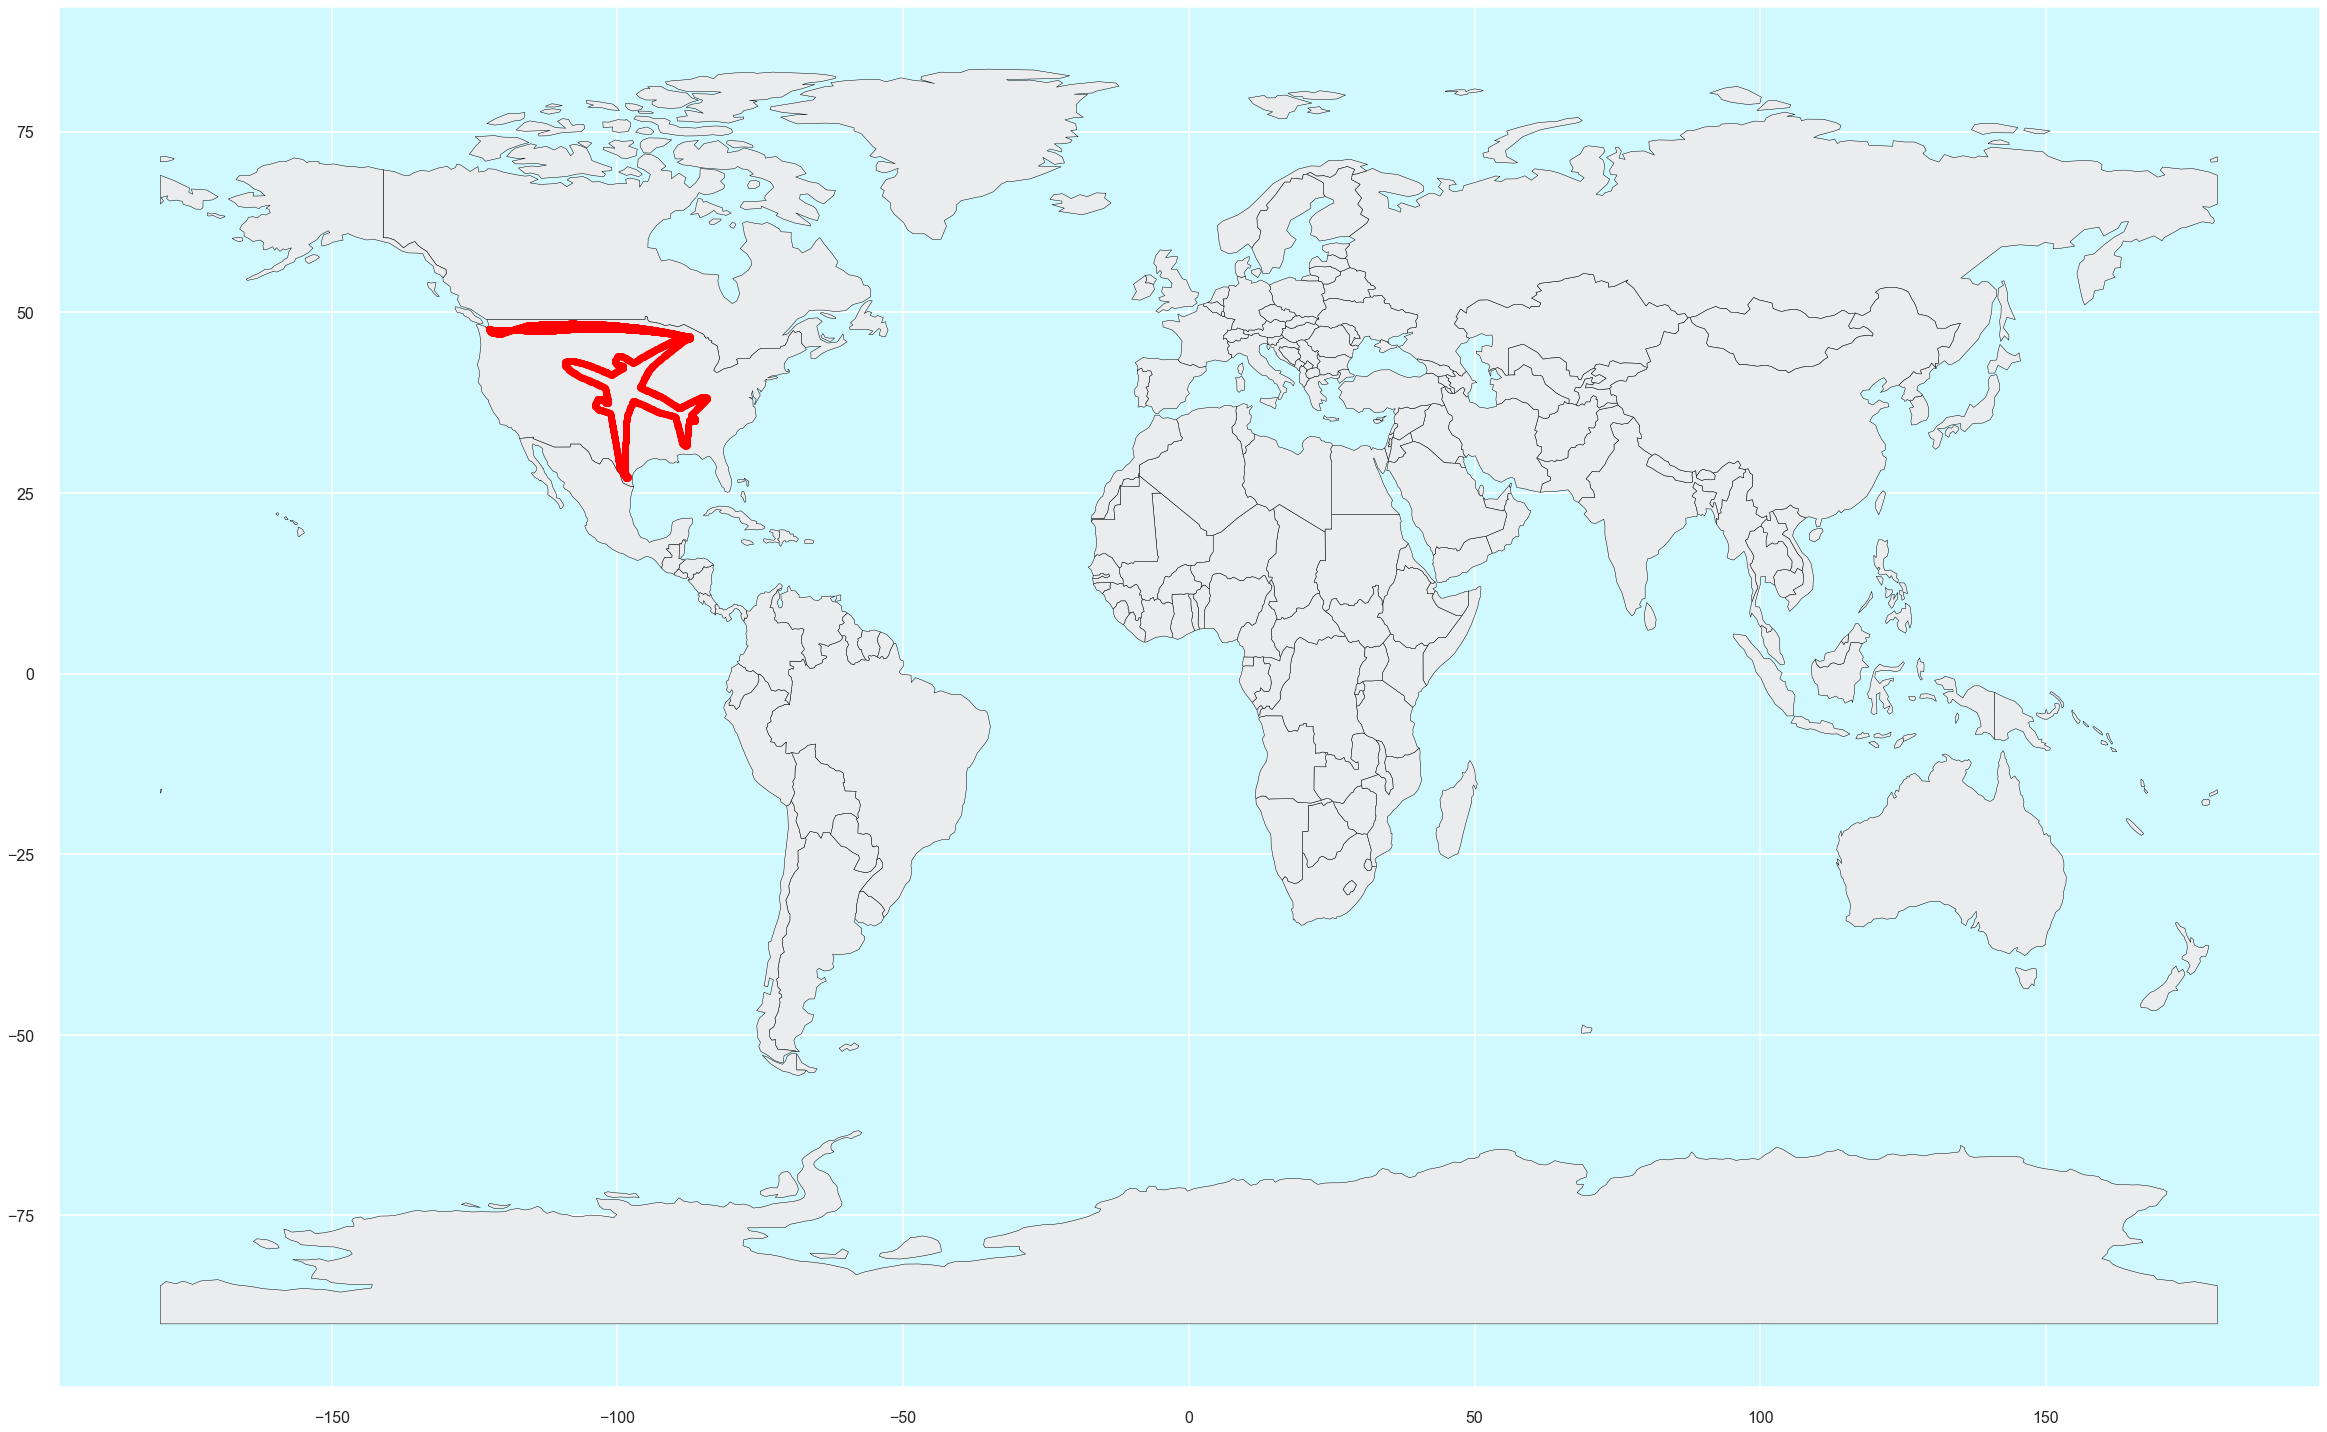

In [87]:
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
fig, ax = plt.subplots(figsize=(2560*px, 1440*px),)  # dpi=200
# ax.set_aspect('equal')
ax.set_facecolor('#d0f9ff')
# ax.set_axis_off();  fig.set_facecolor('#d0f9ff')

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='#ebeced', edgecolor='black')
gdf.plot(ax=ax, marker='o', color='red', markersize=40)

# plt.style.use('default')
# plt.style.use('seaborn-poster')
plt.tight_layout()

plt.show()

In [88]:
# gdf
# world

### 3. Nad którymi krajami przeleciał samolot?

In [89]:
multipunkt = gdf['geometry'].unary_union
filt = world['geometry'].intersects(multipunkt)
world['flewover'] = filt
world[filt].name

4    United States of America
Name: name, dtype: object

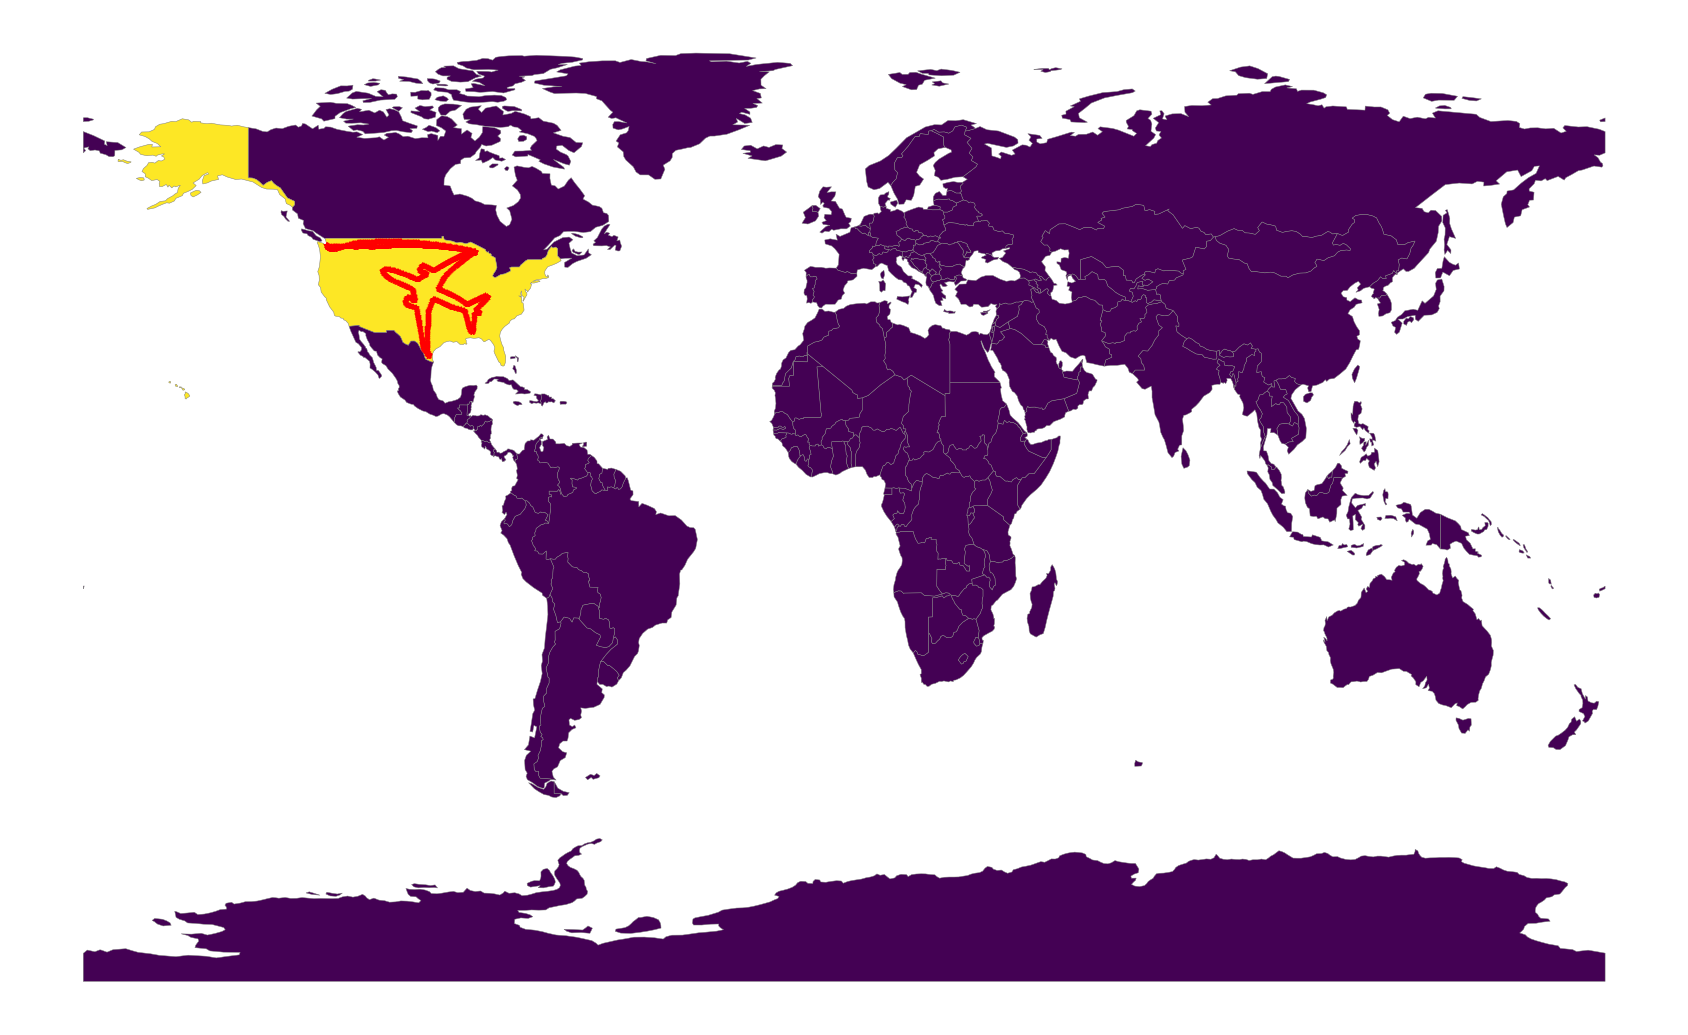

In [90]:
fig, ax = plt.subplots(figsize=(30,30))  # figsize=(,)
ax.set_aspect('equal')
# ax.set_facecolor('#d0f9ff')
ax.set_axis_off();  fig.set_facecolor('white')  #d0f9ff

world.plot(ax=ax, edgecolor='grey', column='flewover', legend=False, cmap=plt.cm.get_cmap('viridis', 2))  # 'Blues'
gdf.plot(ax=ax, marker='*', color='red', markersize=30)

# plt.savefig('mapka.png')  # save as png
plt.show()

### 4. Wykresy w układzie topocentrycznym neu

In [91]:
import plotly.express as px
fig = px.scatter_3d(main_df, y='n', x='e', z='u', color=main_df['u']>0, labels={"color": "u > 0"})

# plotly.offline.plot(fig, filename='neu.html', auto_open=False)  # save as html

fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0}, scene_aspectmode='data')  # , scene_aspectmode='data'
fig.show()

In [92]:
fig = px.line_3d(main_df, y='n', x='e', z='u', color=main_df['u']>0, labels={"color": "u > 0"},)
fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})  # , scene_aspectmode='data'
fig.show()

### 5. Więcej map 

In [93]:
import plotly.express as px
import plotly
# px.set_mapbox_acces_token
fig = px.scatter_geo(main_df,
                     lat='Latitude',
                     lon='Longitude',
                     projection='conic equidistant'
                    )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [105]:
fig = px.scatter_geo(main_df,
                     lat='Latitude',
                     lon='Longitude',
                     hover_name=main_df.index,
                     hover_data=['Meters', 'n', 'e', 'u', 's', 'pfi', 'plam'],
                     projection='orthographic',
#                      animation_frame=main_df.index
                    )
fig.update_geos(fitbounds="locations")  # ,lataxis_showgrid=True, lonaxis_showgrid=True
fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [95]:
fig = px.line_geo(main_df,
                     lat='Latitude',
                     lon='Longitude',
                     hover_name=main_df.index,
                     projection='orthographic',
                    )

fig.update_geos(showcountries=True)  # ,lataxis_showgrid=True, lonaxis_showgrid=True, resolution=50
# plotly.offline.plot(fig, filename='globus.html', auto_open=False)  # save as html
fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [96]:
fig = px.line_geo(main_df,
                     lat='Latitude',
                     lon='Longitude',
                     hover_name=main_df.index,
                     projection='mercator',
                    )

fig.update_geos(showcountries=True)  # ,lataxis_showgrid=True, lonaxis_showgrid=True, resolution=50
# plotly.offline.plot(fig, filename='globus.html', auto_open=False)  # save as html
fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [97]:
fig = px.line_geo(main_df,
                     lat='Latitude',
                     lon='Longitude',
                     hover_name=main_df.index,
                     projection='sinusoidal',  
                      # keeps horizontal lines up to scale, preserves area(same a on map = same irl)
                      # orientation and shape are way off
                    )

fig.update_geos(showcountries=True, lonaxis_showgrid=True, lataxis_showgrid=True)  # ,lataxis_showgrid=True, lonaxis_showgrid=True, resolution=50
# plotly.offline.plot(fig, filename='globus.html', auto_open=False)  # save as html
fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [98]:
fig = px.line_geo(main_df,
                     lat='Latitude',
                     lon='Longitude',
                     hover_name=main_df.index,
                     projection='winkel tripel',  # similar distortion of shape, size, direction
                    )

fig.update_geos(showcountries=True, lonaxis_showgrid=True, lataxis_showgrid=True)  # ,lataxis_showgrid=True, lonaxis_showgrid=True, resolution=50
# plotly.offline.plot(fig, filename='globus.html', auto_open=False)  # save as html
fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# Wykresy

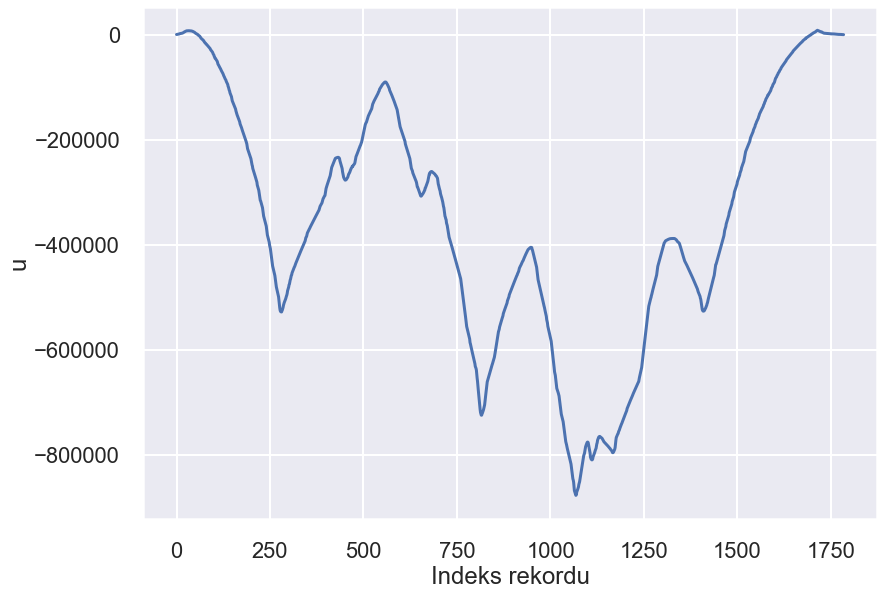

In [99]:
sns.set_theme(context='poster', style='darkgrid')

plt.plot(gdf.index, gdf['u'],)  # gdf.index[::-1]

plt.xlabel('Indeks rekordu')
plt.ylabel('u')

plt.tight_layout()
plt.show()

In [100]:
# gdf[gdf['u'] > -100]['u']  # .describe()

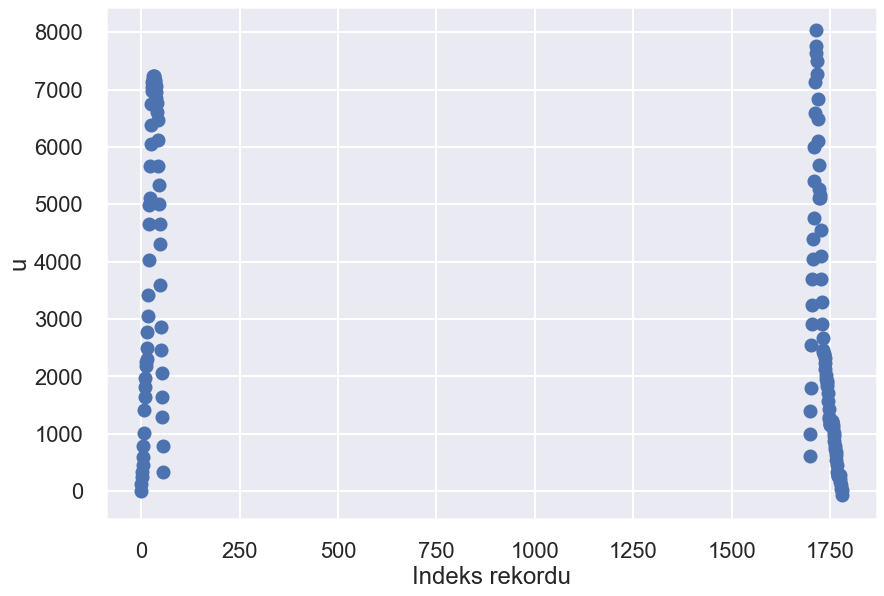

In [101]:
sns.set_theme(context='poster', style='darkgrid')

plt.scatter(gdf[gdf['u'] > -100]['u'].index, gdf[gdf['u'] > -100]['u'])

plt.xlabel('Indeks rekordu')
plt.ylabel('u')

plt.tight_layout()
plt.show()

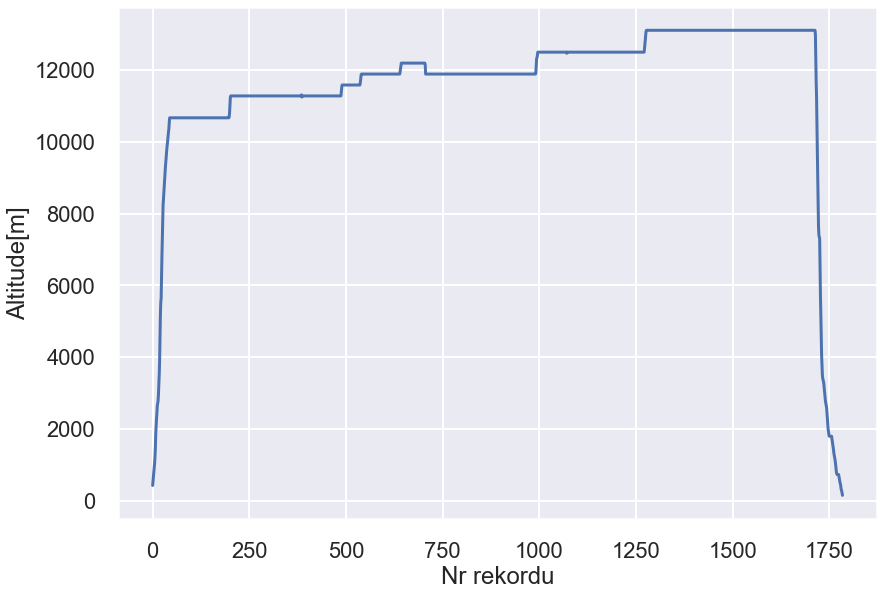

In [102]:
sns.set_theme(context='poster', style='darkgrid')

plt.plot(gdf.index, gdf['Meters'])

plt.xlabel('Nr rekordu')
plt.ylabel('Altitude[m]')

plt.tight_layout()
plt.show()

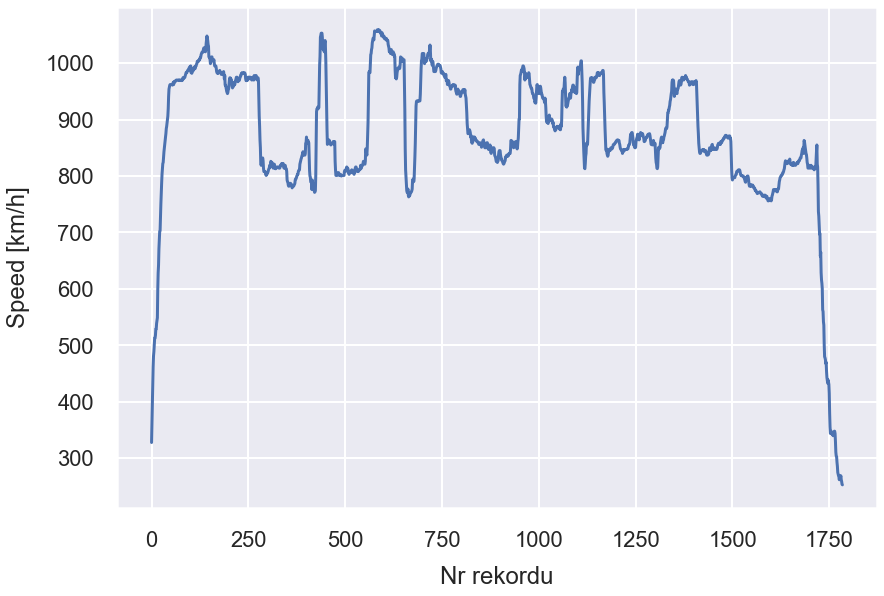

In [103]:
sns.set_theme(context='poster', style='darkgrid')

plt.plot(gdf.index, gdf['kmh'])

plt.xlabel('Nr rekordu', labelpad=15)
plt.ylabel('Speed [km/h]', labelpad=15)

plt.tight_layout()
plt.show()